# Summary

* This is a tutorial on accessing data from the Tahoe-100 TileDB-SOMA database.
  * See the [TileDB-SOMA intro docs](../tiledb-soma/README.md) for general information on the database.
* The database can be accessed directly from Google Cloud Storage (GCS) or copied to a local disk.
  * GCS is recommended for small-scale access.
    * e.g., obtaining the obs (cell) and/or var (gene) metadata.
    * e.g., obtaining count tables for a subset of the data.
  * Local disk is recommended for large-scale access (e.g., model training).
    * If needed, you can copy the entire database via the GCP [gsutil tool](https://cloud.google.com/storage/docs/gsutil).

# Setup

### Installation

If needed, install the necessary dependencies.

You can use the conda environment provided in this git repository. To do so:

```bash
conda env create -f tiledb_conda_env.yml
```

### Database path

Set the path to the database. The database can be cloud hosted (AWS S3 or Google Cloud Storage) or local.

In [1]:
# GCS path, but could be a local (or AWS) path instead
db_uri = "gs://arc-ctc-tahoe100/2025-02-25/tiledb-soma/"

### Load dependencies

* You will source some helper functions to speed up accessing data from the GCS-hosted TileDB-SOMA database.

In [2]:
import sys
sys.path.append('../utils/')
from tiledbsoma_utils import *

# [optional] asthetics settings
pn.theme_set(pn.theme_bw())

# Obs data

Let's first explore the `obs` data (i.e., cell metadata).

See the [README](./README.md#obs-cell-metadata) for descriptions of the metadata fields.

In [6]:
# get obs DataFrame schema
with tiledbsoma_open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
BARCODE_SUB_LIB_ID: large_string
sample: dictionary<values=string, indices=int32, ordered=0>
species: dictionary<values=string, indices=int32, ordered=0>
gene_count: int64
tscp_count: int64
mread_count: int64
bc1_wind: int64
bc2_wind: int64
bc3_wind: int64
bc1_well: dictionary<values=string, indices=int32, ordered=0>
bc2_well: dictionary<values=string, indices=int32, ordered=0>
bc3_well: dictionary<values=string, indices=int32, ordered=0>
id: dictionary<values=string, indices=int32, ordered=0>
drugname_drugconc: dictionary<values=string, indices=int32, ordered=0>
drug: dictionary<values=string, indices=int32, ordered=0>
INT_ID: double
NUM.SNPS: double
NUM.READS: double
demuxlet_call: dictionary<values=string, indices=int32, ordered=0>
BEST.GUESS: dictionary<values=string, indices=int32, ordered=0>
BEST.LLK: double
NEXT.GUESS: dictionary<values=string, indices=int32, ordered=0>
NEXT.LLK: double
DIFF.LLK.BEST.NEXT: double
BEST.POSTERIOR: double
SNG.POSTERIOR: 

### Cell counts per sample

Sum the obs (cell) counts per sample ID.

In [7]:
# count number of obs per sample
counts = get_obs(db_uri, group_by=["sample"], agg_name="count_all")
print(counts.shape)
counts.head()

/home/nickyoungblut/dev/python/arc-virtual-cell-atlas/tahoe-100/../utils/tiledbsoma_utils.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


(1344, 2)


/home/nickyoungblut/dev/python/arc-virtual-cell-atlas/tahoe-100/../utils/tiledbsoma_utils.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,sample,count_all
1250,smp_2553,215364
1340,smp_2643,202116
202,smp_2177,196600
1310,smp_2613,195537
1335,smp_2638,192968


In [10]:
# total obs (cells) in the database
print(f"Total cells: {counts['count_all'].sum()}")

Total cells: 100648790


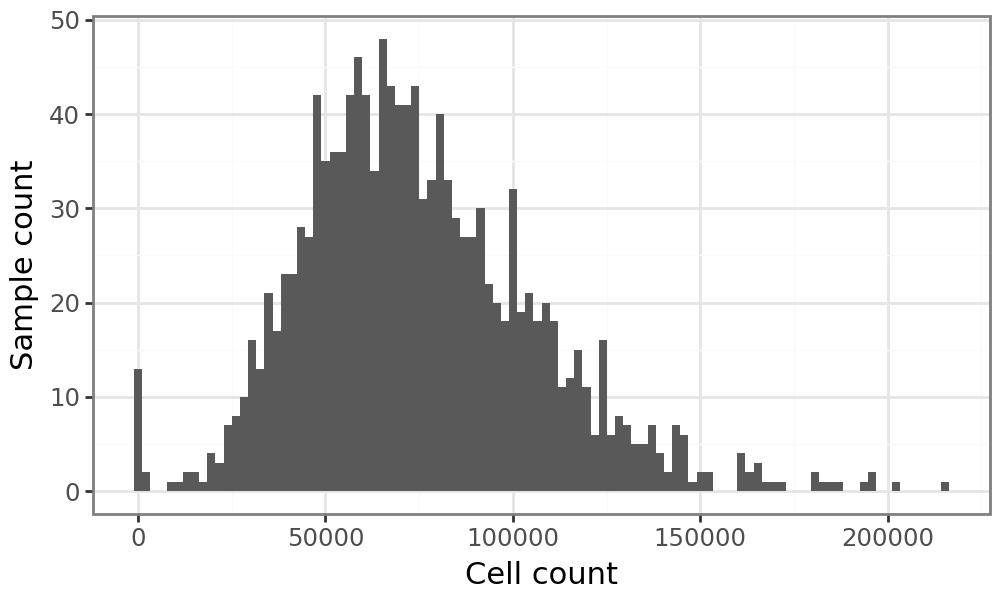

In [13]:
# plot cells per sample
p = (
    pn.ggplot(counts, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cell count", y="Sample count") +
    pn.theme(figure_size=(5,3))
    )
p

### Cell counts per drug

In [14]:
counts = get_obs(db_uri, group_by=["drug"])
print(counts.shape)
counts.head()

/home/nickyoungblut/dev/python/arc-virtual-cell-atlas/tahoe-100/../utils/tiledbsoma_utils.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


(380, 2)


/home/nickyoungblut/dev/python/arc-virtual-cell-atlas/tahoe-100/../utils/tiledbsoma_utils.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,drug,count_all
28,DMSO_TF,2330156
4,Adagrasib,1504078
104,Afatinib,734761
187,Almonertinib (mesylate),622410
114,Binimetinib,574740


In [15]:
# filter to top 30 drugs
top_drugs = counts.sort_values('count_all', ascending=False)["drug"].unique()[:30]
counts_f = counts[counts["drug"].isin(top_drugs)]
counts_f.shape
counts_f.head()

,drug,count_all
28,DMSO_TF,2330156
4,Adagrasib,1504078
104,Afatinib,734761
187,Almonertinib (mesylate),622410
114,Binimetinib,574740


/tmp/ipykernel_2540785/365855227.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


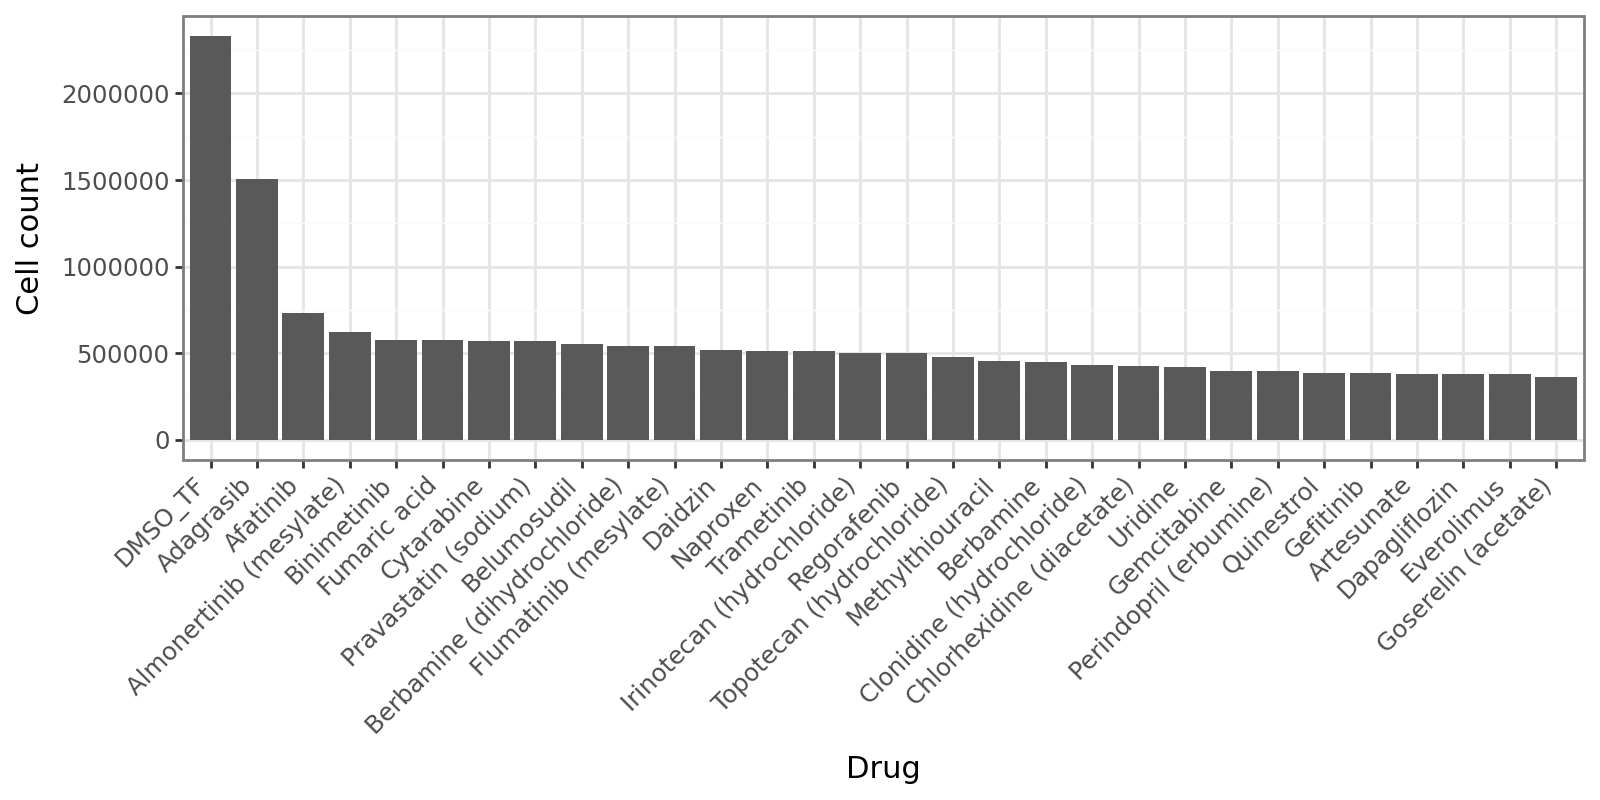

In [16]:
# plot cells per drug

## sort drugs by cell count
counts_f['drug'] = pd.Categorical(
    counts_f['drug'], 
    categories=counts_f.sort_values('count_all', ascending=False)['drug'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(counts_f, pn.aes(x="drug", y="count_all")) + 
    pn.geom_col() +
    pn.labs(x="Drug", y="Cell count") +
    pn.theme(
        figure_size=(8,4),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

### Transcripts (UMIs) per cell

In [17]:
# read in the obs data
counts = get_obs(db_uri, group_by=["tscp_count"])
print(counts.shape)
counts.head()

(47042, 2)


,tscp_count,count_all
1071,1232,46791
1046,1207,46706
1068,1229,46680
1063,1224,46676
1125,1286,46636


In [20]:
# stats
print("-- Transcripts per cell --")
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(counts["tscp_count"].describe())

-- Transcripts per cell --
count    47042
mean     25206
std      16595
min        161
25%      11921
50%      23682
75%      35766
max     235188
Name: tscp_count, dtype: float64


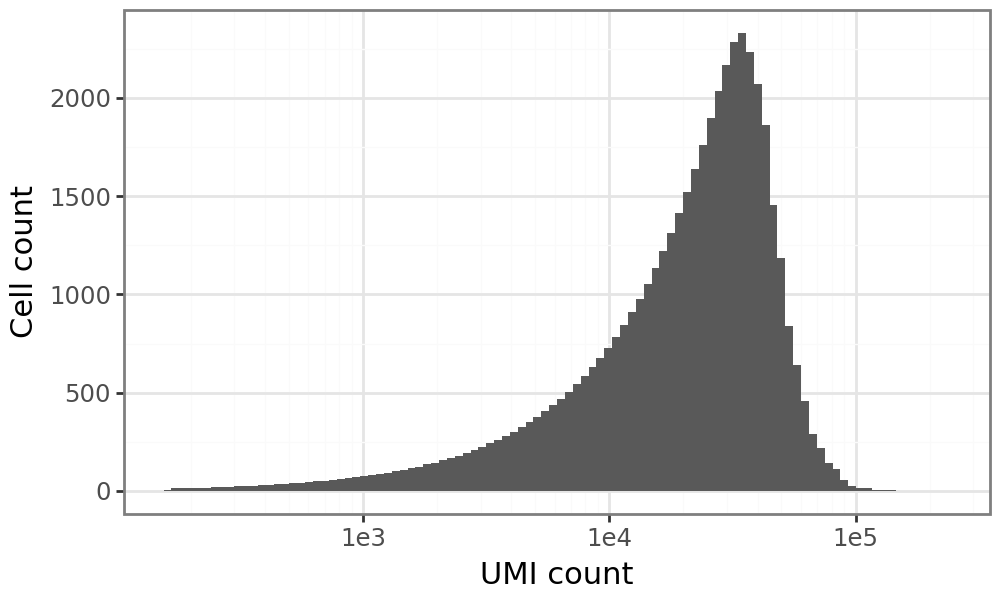

In [21]:
# plot transcripts per cell 
p = (
    pn.ggplot(counts, pn.aes(x="tscp_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="UMI count", y="Cell count") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

### Gene counts per cell

Number of genes per cell with non-zero UMI counts.

In [22]:
# read in the obs data
counts = get_obs(db_uri, columns=["gene_count"])
print(counts.shape)
counts.head()

(100648790, 1)


,gene_count
0,1154
1,1132
2,916
3,1857
4,731


In [24]:
# stats
print("-- Genes per cell --")
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(counts["gene_count"].describe())

-- Genes per cell --
count   100648790
mean         1451
std           812
min           115
25%           898
50%          1255
75%          1776
max         14153
Name: gene_count, dtype: float64


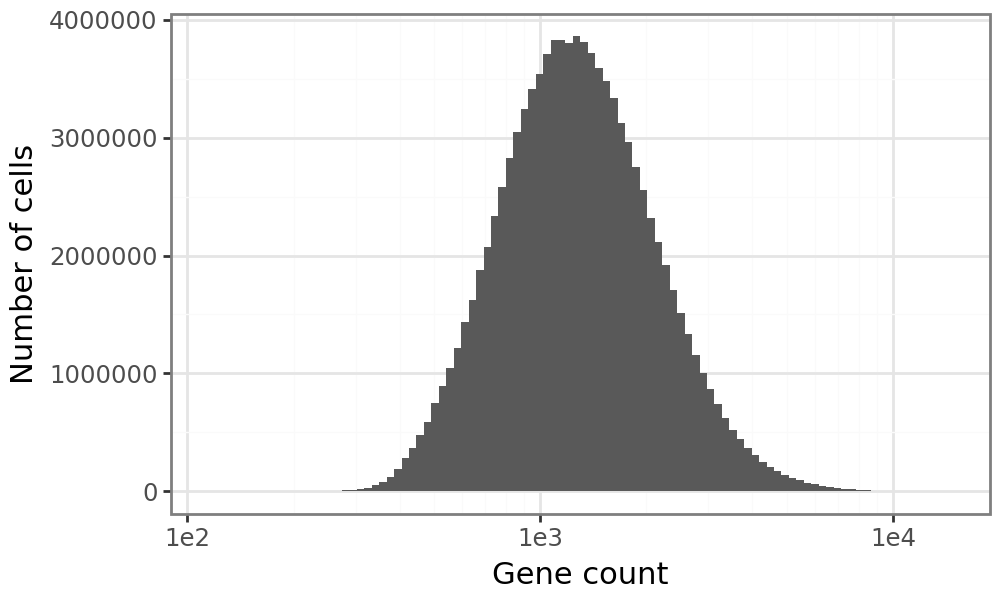

In [25]:
# plot genes per cell (barcode)
p = (
    pn.ggplot(counts, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Gene count", y="Cell count") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

## Queries

Return only certain portions of the dataset (e.g., certain samples or drugs).

In [26]:
# Filter to certain samples
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
df = get_obs(db_uri, columns=["sample"], obs_query=obs_query)
print(df.shape)
df.head()

(258506, 1)


,sample
0,smp_2743
1,smp_2743
2,smp_2743
3,smp_2743
4,smp_2743


In [27]:
# Cell count after filtering out cells with low UMI counts
obs_query = tiledbsoma.AxisQuery(value_filter='tscp_count >= 5000')
df = get_obs(db_uri, columns=["sample"], obs_query=obs_query, group_by=["sample"])
print(f"Number of cells: {df['count_all'].sum()}")

/home/nickyoungblut/dev/python/arc-virtual-cell-atlas/tahoe-100/../utils/tiledbsoma_utils.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/nickyoungblut/dev/python/arc-virtual-cell-atlas/tahoe-100/../utils/tiledbsoma_utils.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Number of cells: 6923499


# Variables

Let's explore the `var` data (i.e., gene metadata).

In [28]:
# get var DataFrame schema
with tiledbsoma_open(db_uri) as exp:
    print(exp.ms["RNA"].var.schema)

soma_joinid: int64 not null
gene_name: large_string
var_id: large_string
organism: large_string


In [29]:
# read in the var level data
with tiledbsoma.Experiment.open(db_uri) as exp:
    df_var = (
        exp.ms["RNA"]
        .var.read()
        .concat()
        .to_pandas()
    )
df_var

,soma_joinid,gene_name,var_id,organism
0,0,TSPAN6,ENSG00000000003,Homo_sapiens
1,1,TNMD,ENSG00000000005,Homo_sapiens
2,2,DPM1,ENSG00000000419,Homo_sapiens
3,3,SCYL3,ENSG00000000457,Homo_sapiens
4,4,C1orf112,ENSG00000000460,Homo_sapiens
...,...,...,...,...
62705,62705,ENSG00000291313,ENSG00000291313,Homo_sapiens
62706,62706,ENSG00000291314,ENSG00000291314,Homo_sapiens
62707,62707,ENSG00000291315,ENSG00000291315,Homo_sapiens
62708,62708,ENSG00000291316,ENSG00000291316,Homo_sapiens


# Convert to anndata

Useful for downstream analysis of the data via scanpy or other tools.

In [3]:
# extract a sample
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_1576"]')
adata = get_anndata(db_uri, obs_query=obs_query, measurement_name="RNA", X_name="X", max_workers=1, obs_columns=["sample", "drug"])
adata

Reading obs metadata...
Found 39 contiguous blocks.
Reading measurement data by contiguous blocks...
Failed to read layer 'X', retrying (1/5)...
Failed to read layer 'X', retrying (2/5)...
  Processed 10 blocks.
  Processed 20 blocks.
  Processed 30 blocks.
Stacking blocks...
Reading var metadata...
Creating AnnData object...
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 58 × 62710
    obs: 'sample', 'drug', 'soma_joinid'
    var: 'soma_joinid', 'gene_name', 'var_id', 'organism'

In [4]:
# Check obs metadata
print(adata.obs.shape)
adata.obs.head()

(58, 3)


,sample,drug,soma_joinid
0,smp_1576,Methylprednisolone succinate,47836531
1,smp_1576,Methylprednisolone succinate,48147189
2,smp_1576,Methylprednisolone succinate,48147190
3,smp_1576,Methylprednisolone succinate,48224257
4,smp_1576,Methylprednisolone succinate,48759496


In [5]:
# Check var metadata
print(adata.var.shape)
adata.var.head()

(62710, 4)


,soma_joinid,gene_name,var_id,organism
0,0,TSPAN6,ENSG00000000003,Homo_sapiens
1,1,TNMD,ENSG00000000005,Homo_sapiens
2,2,DPM1,ENSG00000000419,Homo_sapiens
3,3,SCYL3,ENSG00000000457,Homo_sapiens
4,4,C1orf112,ENSG00000000460,Homo_sapiens


In [9]:
# Summarize the count matrix
for axis,name in zip(range(2), ("cells per gene", "genes per cell")):
    print(f"-- {name} --")
    print(pd.DataFrame(adata.X.getnnz(axis=axis)).describe().to_csv(sys.stdout, header=False))
    print()

-- cells per gene --
count,62710.0
mean,1.4580768617445383
std,4.338408060308752
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,58.0
None

-- genes per cell --
count,58.0
mean,1576.4827586206898
std,878.6165209723692
min,443.0
25%,962.75
50%,1490.0
75%,1854.0
max,4371.0
None



# sessionInfo

In [10]:
!pip list

Package                     Version
--------------------------- -----------
aiobotocore                 2.19.0
aiohappyeyeballs            2.4.4
aiohttp                     3.11.11
aioitertools                0.12.0
aiosignal                   1.3.2
anndata                     0.11.3
array_api_compat            1.10.0
asttokens                   3.0.0
attrs                       25.1.0
beautifulsoup4              4.13.3
botocore                    1.36.3
Brotli                      1.1.0
cached-property             1.5.2
cachetools                  5.5.1
cellxgene-census            1.16.2
certifi                     2024.12.14
cffi                        1.17.1
charset-normalizer          3.4.1
colorama                    0.4.6
comm                        0.2.2
contourpy                   1.3.1
cryptography                44.0.0
cycler                      0.12.1
debugpy                     1.8.12
decorator                   5.1.1
exceptiongroup              1.2.2
executing            